<font size = "5"> Importing Libraries </font>

In [1]:
import numpy as np
from numpy import random as rng
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib import animation, rc
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import scipy
import scipy.signal as signal
import scipy.interpolate as interpolate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
import time as time
import astropy
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
import h5py
import requests
from IPython.core.display import display, HTML
import pickle
import seaborn as sns
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala import coordinates as co
from gala.units import galactic
import re
from astropy.constants import G
import sympy as sy
from sympy import *
from scipy.stats import beta
import os
import emcee
from tqdm import tqdm
import time
from astropy.coordinates.representation import CartesianRepresentation as cartrep
from astropy.coordinates.representation import CartesianDifferential as cartdiff
from astropy.coordinates.representation import PhysicsSphericalRepresentation as physsphrep
from astropy.coordinates.representation import PhysicsSphericalDifferential as physsphdiff
%matplotlib inline

C:\Users\julia\AppData\Local\Temp\ipykernel_20416\1741218034.py:22: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<font size = "5"> Functions </font>

In [2]:
#divide by hubble constant at that snapshot time and multiply by scale factor
def convtoMpc(scale_factor, num):
    inMpc = num / 1000
    scaled = (inMpc * scale_factor)
    return scaled

def quanttonum(quantity):
    array = re.findall(r'\-*\b\d+.*\d+\b', str(quantity))
    newarray = array[0].split(",")
    newarray2 = np.asarray([float(newarray[0]), float(newarray[1]),float(newarray[2])])
    return newarray2

def svtocv(cartpos, sv):
    spherical = convtosph(cartpos)
    x = cartpos[0]
    y = cartpos[1]
    z = cartpos[2]
    p = spherical[0]
    t = spherical[1]
    r = spherical[2]
    vp = sv[0]
    vt = sv[1]
    vr3 = sv[2]
    vx = vr3*np.sin(t)*np.cos(p) + vt*np.cos(t)*np.cos(p) - (vp*np.sin(p))
    vy = vr3*np.sin(t)*np.sin(p) + vt*np.cos(t)*np.sin(p) + vp*np.cos(p)
    vz = vr3*np.cos(t) - (vt*np.sin(t))
    return np.asarray([vx, vy, vz])

#returns vphi, vtheta, vr
def cvtosv(cartpos, cartvel):
    spherical = convtosph(cartpos)
    p = spherical[0]
    t = spherical[1]
    r = spherical[2]
    x = cartpos[0]
    y = cartpos[1]
    z = cartpos[2]
    vx = cartvel[0]
    vy = cartvel[1]
    vz = cartvel[2]  
    vr = vx*np.sin(t)*np.cos(p)+vy*np.sin(t)*np.sin(p)+vz*np.cos(t)
    vp = -vx*np.sin(p)+vy*np.cos(p)
    vt = vx*np.cos(t)*np.cos(p)+vy*np.cos(t)*np.sin(p)-vz*np.sin(t)
    return np.asarray([vp, vt, vr])

#returns phi, theta, r
def convtosph(cartpos):
    repcart = cartrep(cartpos[0]*u.km, cartpos[1]*u.km, cartpos[2]*u.km)
    repsph = repcart.represent_as(physsphrep)
    return quanttonum(str(repsph))

def calcdist(halopos, subhalopos, scale_factor):
    # first is the host halo, second is the potential subhalo
    pos1 = np.zeros(3)
    pos1[0]= halopos[0] * scale_factor
    pos1[1]= halopos[1] * scale_factor
    pos1[2]= halopos[2] * scale_factor
    pos2 = np.zeros(3)
    pos2[0] = subhalopos[0] * scale_factor
    pos2[1] = subhalopos[1] * scale_factor
    pos2[2] = subhalopos[2] * scale_factor
    pos_difference = pos1 - pos2
    distance = np.sqrt(np.dot(pos_difference, pos_difference))
    return distance

#takes three values and returns the magnitude
def mag(magarr):
    magtot = 0
    magtot = np.sqrt(magarr[0]**2 + magarr[1]**2 + magarr[2]**2)
    return magtot

def density(n, r1, r2):
    v1 = (4/3)*np.pi*r1**3
    v2 = (4/3)*np.pi*r2**3
    vol = np.abs(v1 - v2)
    return n/vol

def angcomp(angmom):
    a = np.random.random(3)
    add = a[0] + a[1] + a[2]
    div = a/add
    tru = div*(angmom**2)
    sqrt = np.sqrt(tru)
    return sqrt

def vtvec(angmom, r, cartpos):
    repcart = cartrep(cartpos[0]*u.Mpc, cartpos[1]*u.Mpc, cartpos[2]*u.Mpc)
    repsph = repcart.represent_as(physsphrep)
    numerical = quanttonum(str(repsph))
    theta = numerical[1]
    vp_vt = np.random.random()*2
    tempvt = (angmom/r) * np.sqrt(1/(1+vp_vt**2))
    tempvp = vp_vt * tempvt
    return tempvp, tempvt
    
def vr(posarr, cartvelarr): #both have same units
    x = posarr[0]
    y = posarr[1]
    z = posarr[2]
    vx = cartvelarr[0]
    vy = cartvelarr[1]
    vz = cartvelarr[2]
    return (x*vx+y*vy+z*vz)/(np.sqrt(x**2+y**2+z**2))

#takes three arrays that list positions in x y and z for a subhalo -- for speeding up animation
def cutin20(x, y, z):
    newx = []
    newy = []
    newz = []
    newx.clear()
    newy.clear()
    newz.clear()
    i = 0
    while i < len(x):
        newx.append(x[i])
        newy.append(y[i])
        newz.append(z[i])
        i+=20
    return np.asarray([newx, newy, newz])

def calctime(scalefactor):
    return 28 / (1+(1/scalefactor**2))

<font size = "5">  </font>

<font size = "5">  </font>

<font size = "6"> **Working with Multiple Halos** </font>

<font size = "5"> Downloading Data </font>

In [3]:
h500cdf = pd.read_csv('h500c-75rs.csv')
h500ctop = h500cdf.head(4)
h500c = h500ctop.to_dict('list')
subsdf = pd.read_csv('subs-75-10.csv')
subs = subsdf.to_dict('list')
toth500c = h500cdf.to_dict('list')

In [4]:
h500ctop

,row_id,rockstarId,M500c,snapnum,scale,x,y,z,vx,vy,vz,Rvir,Rs,Mvir
0,1,4287738023,114240000000000,75,0.3303,668.243,200.055,436.354,316.16,176.16,-409.47,1277.47,206.757,137830000000000
1,2,4255065193,100560000000000,75,0.3303,422.128,778.122,756.568,60.72,18.60,3.26,1358.07,409.799,165600000000000
2,3,4280692873,131300000000000,75,0.3303,606.639,485.140,619.933,-120.56,-123.49,210.62,1367.87,258.542,169220000000000
3,4,4262605859,105510000000000,75,0.3303,505.444,592.763,248.737,82.60,-408.38,306.08,1236.80,235.536,125080000000000


<font size = "5"> Finding Subhalos for Halos </font>

In [5]:
for i in range(len(toth500c['x'])):
    globals()['h' + str(i)] = {'subid' : [], 'radius' : [], 'vx':[], 'vy':[], 'vz':[], 'm' : [], 'x':[], 'y':[], 'z':[]}
    for j in tqdm(range(len(subs['x']))):
        halo = np.asarray([toth500c['x'][i], toth500c['y'][i], toth500c['z'][i]])
        sub = np.asarray([subs['x'][j], subs['y'][j], subs['z'][j]])
        rad = 0
        rad = calcdist(halo, sub, subs['scale'][0])
        if rad >= 1.5*((toth500c['Rvir'][i]*subs['scale'][0])/1000) and rad <= 5:
            globals()['h' + str(i)]['subid'].append(subs['rockstarId'][j])
            globals()['h' + str(i)]['radius'].append(rad) #in Mpc
            globals()['h' + str(i)]['x'].append((subs['x'][j] - toth500c['x'][i])*subs['scale'][0]) #Mpc
            globals()['h' + str(i)]['y'].append((subs['y'][j] - toth500c['y'][i])*subs['scale'][0]) #Mpc
            globals()['h' + str(i)]['z'].append((subs['z'][j] - toth500c['z'][i])*subs['scale'][0]) #Mpc
            globals()['h' + str(i)]['vx'].append(subs['vx'][j] - toth500c['vx'][i]) #km/s
            globals()['h' + str(i)]['vy'].append(subs['vy'][j] - toth500c['vy'][i]) #km/s
            globals()['h' + str(i)]['vz'].append(subs['vz'][j] - toth500c['vz'][i]) #km/s
            globals()['h' + str(i)]['m'].append(subs['M200c'][j]*subs['scale'][0]) #in Msun
        else:
            pass

100%|██████████| 10000000/10000000 [01:50<00:00, 90361.45it/s]


In [6]:
pd.DataFrame(h0)

,subid,radius,vx,vy,vz,m,x,y,z
0,4287737914,3.209383,227.72,-475.58,345.60,5.169856e+12,-2.124159,0.545656,-2.343148
1,4287739173,2.780223,-67.87,172.09,240.35,3.291208e+12,-1.373387,-2.057439,-1.269013
2,4287733673,4.490730,-400.03,-589.32,121.56,2.894914e+12,2.473617,2.915228,-2.355700
3,4287739001,4.330156,49.82,-367.42,637.30,2.669650e+12,-1.257122,-0.139717,-4.141301
4,4287733561,4.871643,-474.70,-317.16,601.67,2.564746e+12,1.366451,2.104672,-4.175653
...,...,...,...,...,...,...,...,...,...
269,4287737952,3.609696,481.87,-710.03,733.96,7.458504e+10,-2.410529,0.686033,-2.597810
270,4287738722,1.803492,-0.35,-535.58,-182.64,7.458504e+10,-1.038794,1.150765,0.921537
271,4287737643,3.294265,-557.74,217.64,442.50,7.657345e+10,2.691284,-1.001800,-1.614176
272,4287737422,1.209676,-578.66,-984.23,148.64,7.607800e+10,0.646727,0.947631,-0.383478


<font size = "5"> Calculating Angular Momentum Over Mass for Subhalos </font>

In [7]:
for i in range(len(toth500c['x'])):
    globals()['h' + str(i)]['totang'] = []
    globals()['h' + str(i)]['angx'] = []
    globals()['h' + str(i)]['angy'] = []
    globals()['h' + str(i)]['angz'] = []
    globals()['h'+str(i)]['vr'] = []
    for j in range(len(globals()['h' + str(i)]['x'])):
        posarr = np.asarray([globals()['h' + str(i)]['x'][j],globals()['h' + str(i)]['y'][j], globals()['h' + str(i)]['z'][j]]) #Mpc
        velarr = np.asarray([globals()['h' + str(i)]['vx'][j],globals()['h' + str(i)]['vy'][j],globals()['h' + str(i)]['vz'][j]]) #km/s
        ang = np.cross(posarr, velarr) #Mpc*km/s
        globals()['h' + str(i)]['angx'].append(ang[0])
        globals()['h' + str(i)]['angy'].append(ang[1])
        globals()['h' + str(i)]['angz'].append(ang[2])
        globals()['h' + str(i)]['totang'].append(np.sqrt(ang[0]**2 + ang[1]**2 + ang[2]**2))
        globals()['h'+str(i)]['vr'].append(vr(posarr, velarr))

<font size = "5"> Splitting the Angular Momentum Distribution </font>

In [8]:
for i in range(len(toth500c['x'])):
    for j in range(5):
        globals()['angrad'+str(i)+str(j)] = []
        globals()['vrrad'+str(i)+str(j)] = []
        globals()['vxrad'+str(i)+str(j)] = []
        globals()['angrad'+str(i)+str(j)].clear()
        globals()['vrrad'+str(i)+str(j)].clear()
        globals()['vxrad'+str(i)+str(j)].clear()
        ang = np.asarray(h0['totang'])
        vr = np.asarray(h0['vr'])
        vx = np.asarray(h0['vx'])
        rad = np.asarray(h0['radius'])
        mask = np.logical_and(rad > j, rad < j + 1)
        globals()['angrad'+str(i)+str(j)] = ang[mask]
        globals()['vrrad'+str(i)+str(j)] = vr[mask]
        globals()['vxrad'+str(i)+str(j)] = vx[mask]

<font size = "5"> Angular Momentum at Different Radii </font>

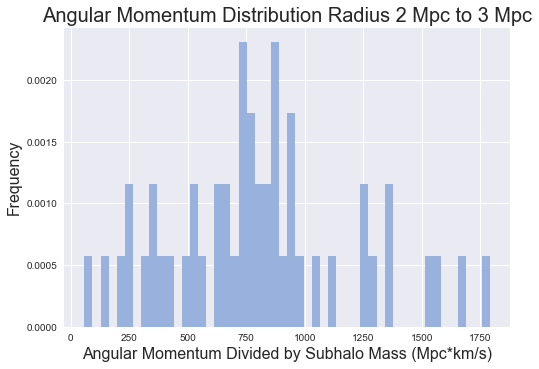

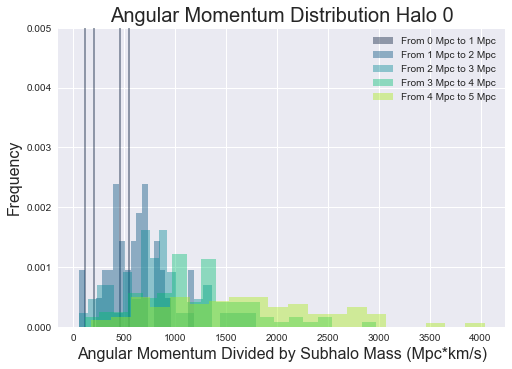

In [9]:
%matplotlib inline
plt.style.use('seaborn')
plt.xlabel('Angular Momentum Divided by Subhalo Mass (Mpc*km/s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Angular Momentum Distribution Radius 2 Mpc to 3 Mpc', fontsize = 20)
plt.hist(angrad02, bins = 50, density = True, color = "#99b2dd")
plt.show()

%matplotlib inline
plt.style.use('seaborn')
plt.xlabel('Angular Momentum Divided by Subhalo Mass (Mpc*km/s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Angular Momentum Distribution Halo 0', fontsize = 20)
co = np.asarray(["#051937", "#004d7a", "#008793", "#00bf72", "#a8eb12"])
plt.ylim(0, 0.005)
for i in range(5):
    plt.hist(globals()['angrad0'+ str(i)], bins = 20, density = True, alpha = 0.4, color = co[i], label = 'From '+ str(i)+' Mpc to '+str(i+1)+' Mpc')
plt.legend()
plt.show()

<font size = "5"> Initial Distributions for Data -- Angmom, Radius, Vx </font>

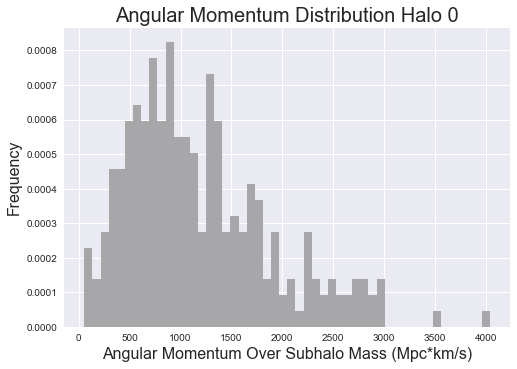

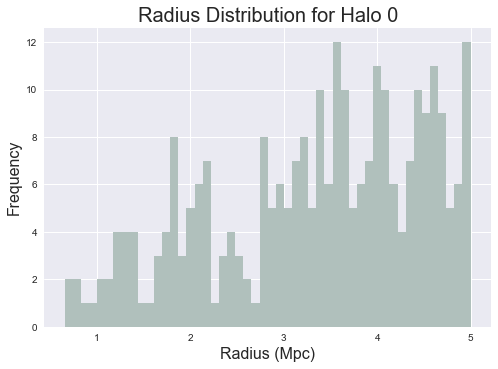

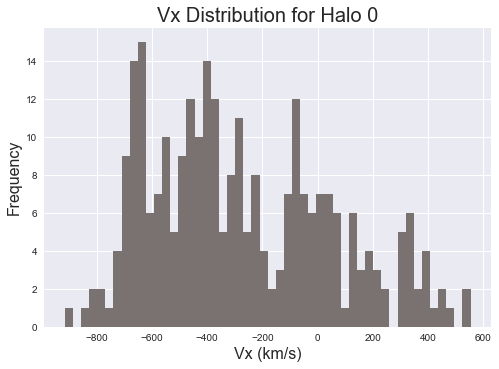

In [10]:
%matplotlib inline
plt.style.use('seaborn')
plt.xlabel('Angular Momentum Over Subhalo Mass (Mpc*km/s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Angular Momentum Distribution Halo 0', fontsize = 20)
plt.hist(h0['totang'], density = True, bins = 50, color = "#a7a7a9")
plt.show()

plt.style.use('seaborn')
plt.xlabel('Radius (Mpc)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Radius Distribution for Halo 0', fontsize = 20)
plt.hist(h0['radius'], bins = 50, color = "#b0c0bc")
plt.show()

%matplotlib inline
plt.style.use('seaborn')
plt.xlabel('Vx (km/s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Vx Distribution for Halo 0', fontsize = 20)
plt.hist(h0['vx'], bins = 50, color = "#797270")
plt.show()

<font size = "5">   </font>

<font size = "5">   </font>

<font size = "6"> **Plotting Orbits with Gala** </font>

<font size = "5"> Finding Velocities </font>

In [11]:
record = []
record.clear()
import re

for i in range(len(toth500c['x'])):
    globals()['vel' + str(i)] = []
    globals()['pos' + str(i)] = []
    globals()['vel' + str(i)].clear()
    globals()['pos' + str(i)].clear() 
    for j in range(1000):
        number2 = (np.random.random() * len(globals()['h' + str(i)]['x'])) -1
        initrad = globals()['h' + str(i)]['radius'][round(number2)] #in Mpc
        poss = angcomp(initrad)
        poss[0] = poss[0] * ((np.random.random() > 0.5)*2 - 1)
        poss[1] = poss[1] * ((np.random.random() > 0.5)*2 - 1)
        poss[2] = poss[2] * ((np.random.random() > 0.5)*2 - 1)
        velo = np.empty(3)
        sphvel = 0
        if initrad > 0 and initrad < 1:
            number = (np.random.random() * len(globals()['angrad' + str(i)+'0'])) -1 
            angg = globals()['angrad'+ str(i)+'0'][round(number)] #in Mpc*km/s
            vrr = (globals()['vrrad' +str(i)+'0'][round(number)]) #in km/s
            vp, vt = vtvec(angg, initrad, poss)
            sphvel = np.asarray([vp, vt, vrr])
            record.append(np.asarray([vrr, angg, poss, sphvel]))
            finalvel = svtocv(poss, sphvel)
        if initrad > 1 and initrad < 2:
            number = (np.random.random() * len(globals()['angrad' + str(i)+'1'])) -1
            angg = globals()['angrad'+ str(i)+'1'][round(number)]
            vrr = (globals()['vrrad' +str(i)+'1'][round(number)])
            vp, vt = vtvec(angg, initrad, poss)
            sphvel = np.asarray([vp, vt, vrr])
            record.append(np.asarray([vrr, angg, poss, sphvel]))
            finalvel = svtocv(poss, sphvel)
        if initrad > 2 and initrad < 3:
            number = (np.random.random() * len(globals()['angrad' + str(i)+'2'])) -1
            angg = globals()['angrad'+ str(i)+'2'][round(number)]
            vrr = (globals()['vrrad' +str(i)+'2'][round(number)])
            vp, vt = vtvec(angg, initrad, poss)
            sphvel = np.asarray([vp, vt, vrr])
            record.append(np.asarray([vrr, angg, poss, sphvel]))
            finalvel = svtocv(poss, sphvel)
        if initrad > 3 and initrad < 4:
            number = (np.random.random() * len(globals()['angrad' + str(i)+'3'])) -1
            angg = globals()['angrad'+ str(i)+'3'][round(number)]
            vrr = (globals()['vrrad' +str(i)+'3'][round(number)])
            vp, vt = vtvec(angg, initrad, poss)
            sphvel = np.asarray([vp, vt, vrr])
            record.append(np.asarray([vrr, angg, poss, sphvel]))
            finalvel = svtocv(poss, sphvel)
        if initrad > 4 and initrad < 5:
            number = (np.random.random() * len(globals()['angrad' + str(i)+'4'])) -1
            angg = globals()['angrad'+ str(i)+'4'][round(number)]
            vrr = (globals()['vrrad' +str(i)+'4'][round(number)])
            vp, vt = vtvec(angg, initrad, poss)
            sphvel = np.asarray([vp, vt, vrr])
            record.append(np.asarray([vrr, angg, poss, sphvel]))
            finalvel = svtocv(poss, sphvel)
        else:
            pass
        globals()['vel' + str(i)].append(finalvel)
        globals()['pos' + str(i)].append(poss)

C:\Users\julia\AppData\Local\Temp\ipykernel_20416\306836039.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  record.append(np.asarray([vrr, angg, poss, sphvel]))
C:\Users\julia\AppData\Local\Temp\ipykernel_20416\306836039.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  record.append(np.asarray([vrr, angg, poss, sphvel]))
C:\Users\julia\AppData\Local\Temp\ipykernel_20416\306836039.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

<font size = "5"> Calculating Angular Momentum and Vr of Simulation Subhalos </font>

In [12]:
def vr(posarr, cartvelarr): #both have same units
    x = posarr[0]
    y = posarr[1]
    z = posarr[2]
    vx = cartvelarr[0]
    vy = cartvelarr[1]
    vz = cartvelarr[2]
    return (x*vx+y*vy+z*vz)/(np.sqrt(x**2+y**2+z**2))

In [13]:
#for cartesian coordinates!
for j in range(len(h500c['x'])):
    globals()['simangmom' + str(j)] = []
    globals()['initialvr' + str(j)] = []
    globals()['simangmom' + str(j)].clear()
    globals()['initialvr' + str(j)].clear()
    for i in range(len(globals()['vel'+str(j)])):
        angm = np.cross(globals()['pos'+str(j)][i], globals()['vel'+str(j)][i])
        totangm = mag(angm)
        globals()['simangmom' + str(j)].append(totangm)
        globals()['initialvr' + str(j)].append(vr(globals()['pos'+str(j)][i],globals()['vel'+str(j)][i]))

<font size = "5"> Comparing Simulation to Real Data - Angular Momentum </font>

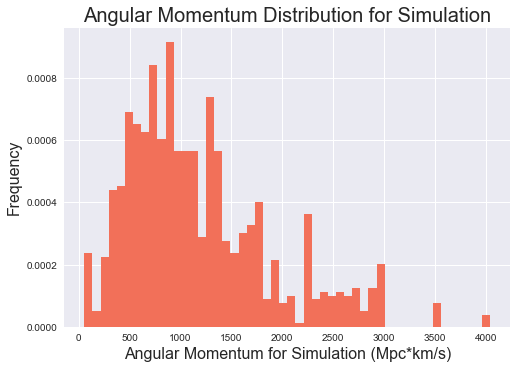

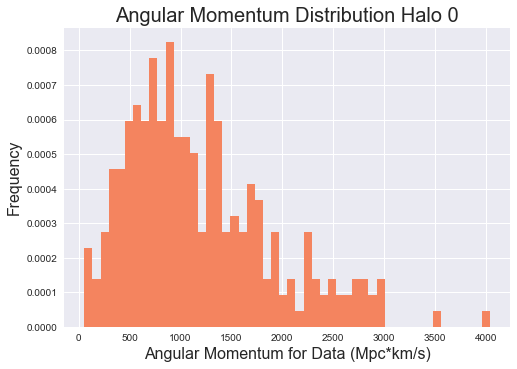

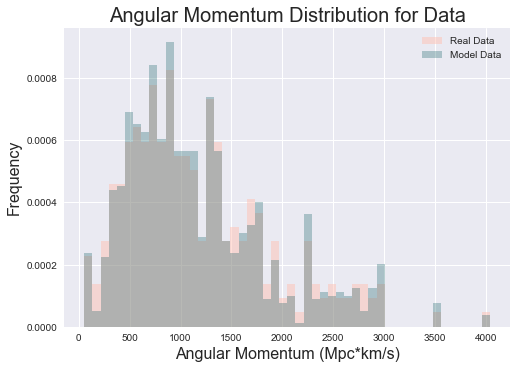

In [14]:
%matplotlib inline
plt.style.use('seaborn')
plt.xlabel('Angular Momentum for Simulation (Mpc*km/s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Angular Momentum Distribution for Simulation', fontsize = 20)
plt.hist(simangmom0, density = True, bins = 50, color = "#f27059")
plt.show()

%matplotlib inline
plt.style.use('seaborn')
plt.xlabel('Angular Momentum for Data (Mpc*km/s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Angular Momentum Distribution Halo 0', fontsize = 20)
plt.hist(h0['totang'], density = True, bins = 50, color = "#f4845f")
plt.show()

%matplotlib inline
plt.style.use('seaborn')
plt.xlabel('Angular Momentum (Mpc*km/s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Angular Momentum Distribution for Data', fontsize = 20)
plt.hist(h0['totang'], density = True, bins = 50, alpha = 0.5, color = '#ffc2b4', label = 'Real Data')
plt.hist(simangmom0, density = True, bins = 50, alpha = 0.3, color = '#156064', label = 'Model Data')
plt.legend()
plt.show()

<font size = "5"> Comparing Simulation to Real Data - Radial Velocity </font>

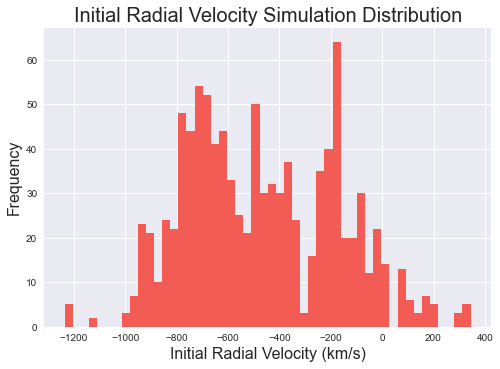

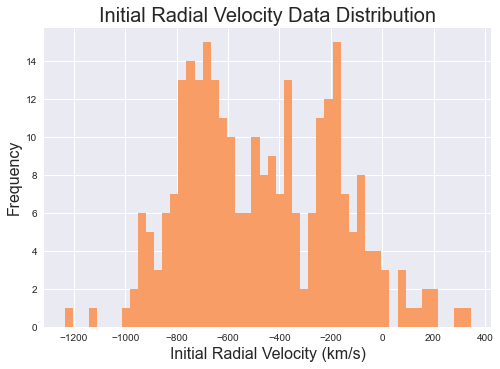

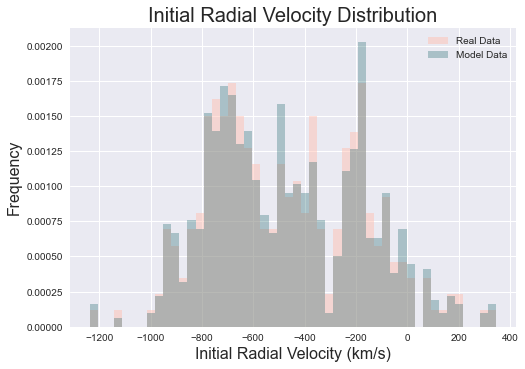

In [15]:
%matplotlib inline
plt.style.use('seaborn')
plt.xlabel('Initial Radial Velocity (km/s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Initial Radial Velocity Simulation Distribution', fontsize = 20)
plt.hist(initialvr0, bins = 50, color = "#f25c54")
plt.show()

%matplotlib inline
plt.style.use('seaborn')
plt.xlabel('Initial Radial Velocity (km/s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Initial Radial Velocity Data Distribution', fontsize = 20)
plt.hist(h0['vr'], bins = 50, color = "#f79d65")
plt.show()

%matplotlib inline
plt.style.use('seaborn')
plt.xlabel('Initial Radial Velocity (km/s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Initial Radial Velocity Distribution', fontsize = 20)
plt.hist(h0['vr'], density = True, bins = 50, alpha = 0.5, color = '#ffc2b4', label = 'Real Data')
plt.hist(initialvr0, density = True, bins = 50, alpha = 0.3, color = '#156064', label = 'Model Data')
plt.legend()
plt.show()

<font size = "5"> Calculating Orbits for Halos </font>

In [16]:
def xyzradius(x_array, y_array, z_array):
    r_array = np.zeros(len(x_array))
    for i in range(len(x_array)):
        r_array[i] = np.sqrt((x_array[i]**2)+(y_array[i]**2)+(z_array[i]**2))
    return r_array 

In [44]:
for i in range(len(h500c['x'])):
    Mv = h500c['Mvir'][i]*subs['scale'][i]
    globals()['g' + str(i)] = {'Subhalo_ID' : [], 'Orb_x' : [], 'Orb_y' : [], 'Orb_z' : [], 'Vx':[],
                               'Vy':[], 'Vz':[], 'Time' : [], 'Radius' :[],'Vtot':[], 'Vr' : [], 'KE':[], 'PE':[]}
    globals()['vtot' + str(i)] = []
    globals()['vr' + str(i)] = []
    globals()['vtot' + str(i)].clear()
    globals()['vr' + str(i)].clear()
    for j in tqdm(range(len(globals()['vel' + str(i)]))):
        globals()['vtot' + str(i)].clear()
        globals()['vr' + str(i)].clear()
        pot = gp.NFWPotential.from_M200_c(Mv*u.Msun, c = h500c['Rvir'][i]/h500c['Rs'][i], rho_c = None, units=galactic)
        ics = gd.PhaseSpacePosition(pos = globals()['pos' + str(i)][j] * u.Mpc, vel= globals()['vel' + str(i)][j]*u.km/u.s )
        orbit = gp.Hamiltonian(pot).integrate_orbit(ics, dt=4*u.Myr, n_steps=12500)
        x_orbit, y_orbit, z_orbit = np.asarray(orbit.x), np.asarray(orbit.y), np.asarray(orbit.z)
        vx_orb, vy_orb, vz_orb = np.asarray(orbit.v_x), np.asarray(orbit.v_y), np.asarray(orbit.v_z)
        ke_orb, pe_orb = np.asarray(orbit.kinetic_energy()), np.asarray(orbit.potential_energy()) 
        for k in range(len(vx_orb)):
            globals()['vtot' + str(i)].append(np.sqrt(vx_orb[k]**2 + vy_orb[k]**2 + vz_orb[k]**2))
            posit = np.empty(3)
            veloc = np.empty(3)
            posit = np.asarray([x_orbit[k],y_orbit[k],z_orbit[k]])
            veloc = np.asarray([vx_orb[k], vy_orb[k], vz_orb[k]])
            globals()['vr' + str(i)].append(vr(veloc, posit))
        globals()['g' + str(i)]['Subhalo_ID'].append(j)
        globals()['g' + str(i)]['Orb_x'].append(x_orbit)
        globals()['g' + str(i)]['Orb_y'].append(y_orbit)
        globals()['g' + str(i)]['Orb_z'].append(z_orbit)
        globals()['g' + str(i)]['KE'].append(ke_orb)
        globals()['g' + str(i)]['PE'].append(pe_orb)
        globals()['g' + str(i)]['Vx'].append(vx_orb)
        globals()['g' + str(i)]['Vy'].append(vy_orb)
        globals()['g' + str(i)]['Vz'].append(vz_orb)
        globals()['g' + str(i)]['Time'].append(np.asarray(orbit.t))
        globals()['g' + str(i)]['Radius'].append(xyzradius(x_orbit, y_orbit, z_orbit))
        globals()['g' + str(i)]['Vtot'].append(np.asarray(globals()['vtot' + str(i)]))
        globals()['g' + str(i)]['Vr'].append(np.asarray(globals()['vr' + str(i)]))

100%|██████████| 1000/1000 [03:07<00:00,  5.34it/s]


<font size = "5"> Plotting Orbits </font>

<IPython.core.display.Javascript object>


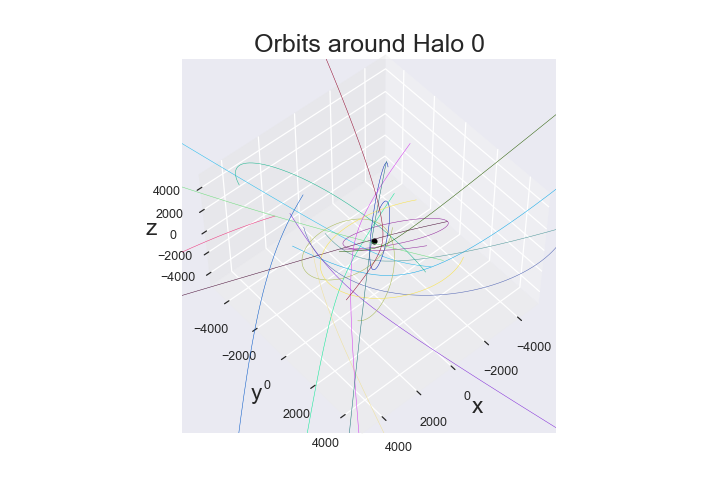

<IPython.core.display.Javascript object>


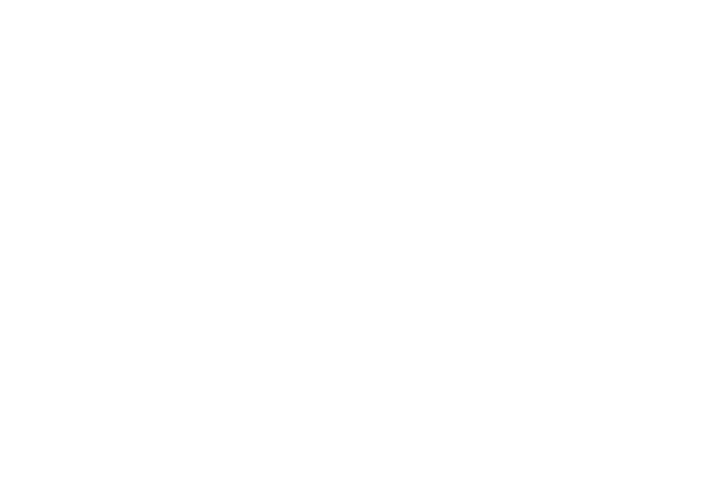

In [70]:
%matplotlib notebook
plt.style.use('seaborn')
ax = plt.axes(projection='3d')
fig = plt.figure()
ax.set_xlabel('x', fontsize = 18)
ax.set_ylabel('y', fontsize = 18)
ax.set_zlabel('z', fontsize = 18)
ax.set_title('Orbits around Halo 0', fontsize = 20)
ax.scatter3D(0, 0, 0, s = 20, c ='k')
ax.set_xlim(-5000, 5000)
ax.set_ylim(-5000, 5000)
ax.set_zlim(-5000, 5000)

for i in range(20):
    r = np.random.random()
    g = np.random.random()
    b = np.random.random()
    color = (r,g,b)
    ax.plot3D(g0['Orb_x'][i], g0['Orb_y'][i], g0['Orb_z'][i],
              color = color, linewidth = 0.4)

<font size = "5">   </font>

<font size = "5">   </font>

<font size = "6"> **Number Density Profile** </font>

<font size = "5"> Finding Radii at Different Times </font>

In [71]:
numsplit = 5
maxnum = max(g0['Time'][0])
space = maxnum/numsplit
for i in range(numsplit):
    globals()['cut'+str(i)] = np.where(g0['Time'][0] == space*(i+1))

In [72]:
for k in range(numsplit):
    for j in range(len(h500c['x'])):
        globals()['r'+str(j)+'_'+str(k+1)] = []
        globals()['r'+str(j)+'_'+str(k+1)].clear()
        for i in range(len(globals()['vel' + str(j)])):
             globals()['r'+str(j)+'_'+str(k+1)].append(globals()['g' + str(j)]['Radius'][i][globals()['cut'+str(k)][0][0]])

<font size = "5"> Plotting Histograms at Different Times </font>

In [73]:
#each r0_1 has a list of the radii for the time given for all of the subhalos calculated
for i in range(1):
    j = 1
    while j <= 5:
        a, b = np.histogram(globals()['r'+str(i)+'_'+str(j)], bins = 100, range = (0,2000))
        #a is the amount in each bin
        #b is an array of the borders for each bin in km for radius
        globals()['d'+str(i)+'_'+str(j)] = []
        globals()['b'+str(i)+'_'+str(j)] = []
        for k in range(len(a)):
            globals()['d'+str(i)+'_'+str(j)].append(density(a[k], b[k], b[k+1]))
        for l in range(len(b)-1):
            globals()['b'+str(i)+'_'+str(j)].append((b[l]+b[l+1])/2)
        j += 1

<font size = "5"> Radius v. Number Density </font>

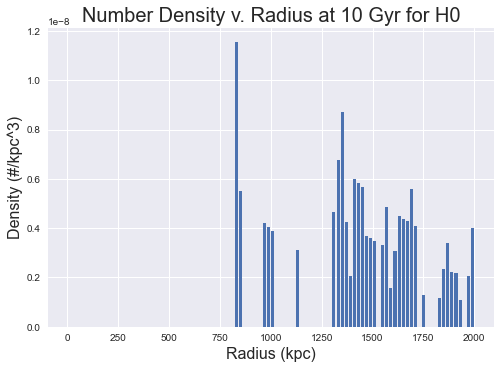

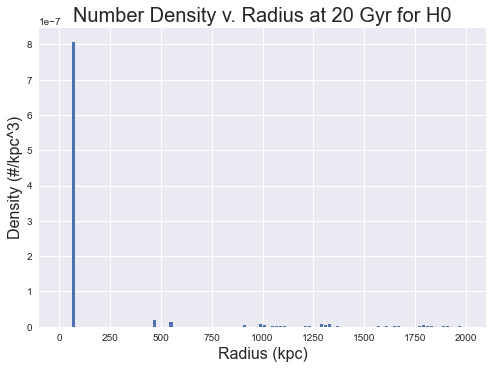

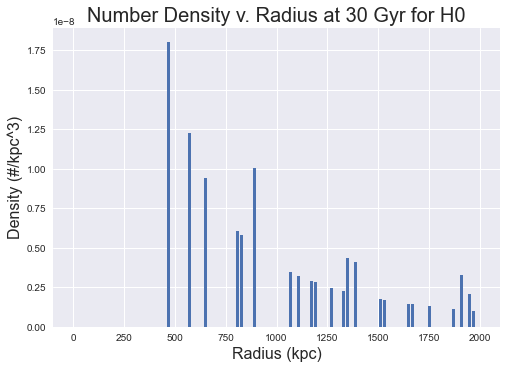

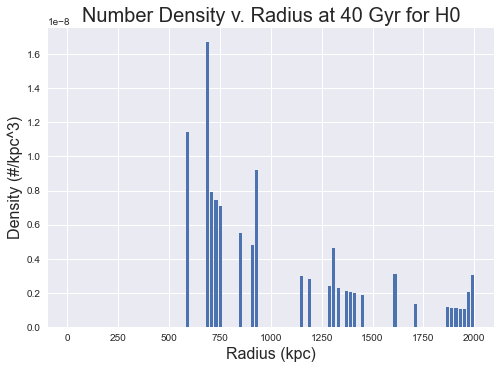

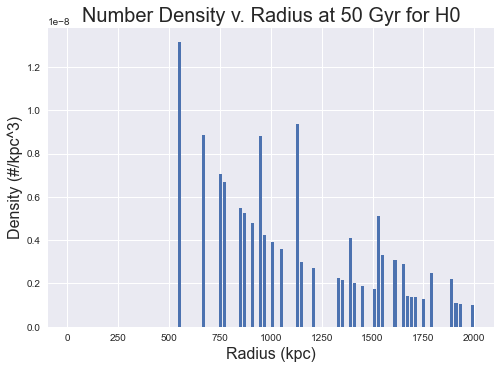

In [74]:
for i in range(1):
    for j in range(1,6):
        %matplotlib inline
        plt.style.use('seaborn')
        plt.title('Number Density v. Radius at '+ str(10*j)+' Gyr for H'+str(i), fontsize = 20)
        plt.xlabel('Radius (kpc)', fontsize = 16)
        plt.ylabel('Density (#/kpc^3)', fontsize = 16)
        plt.bar(globals()['b'+str(i)+'_'+str(j)], globals()['d'+str(i)+'_'+str(j)], width = 15, align = 'center')
        plt.show()

<font size = "5"> Radius v. Number Density Plots </font>

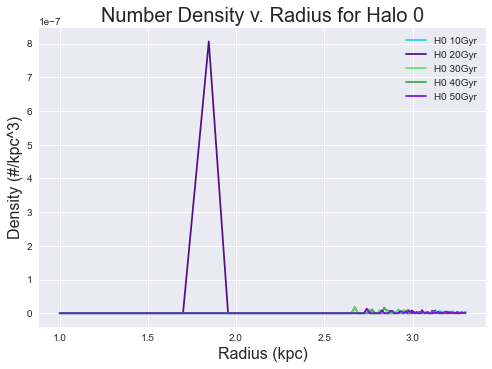

In [50]:
%matplotlib inline
plt.style.use('seaborn')
plt.title('Number Density v. Radius for Halo 0', fontsize = 20)
plt.xlabel('Radius (kpc)', fontsize = 16)
plt.ylabel('Density (#/kpc^3)', fontsize = 16)

for i in range(1):
    for j in range(1,1+numsplit):
        r = np.random.random()
        g = np.random.random()
        b = np.random.random()
        color = (r,g,b)
        plt.plot(np.log10(globals()['b'+str(i)+'_'+str(j)]), globals()['d'+str(i)+'_'+str(j)], color=color, label = 'H'+str(i)+' '+str(10*j)+'Gyr')
plt.legend()

In [75]:
for i in range(len(h500c['x'])):
    j = 1
    while j <= 5:
        a, b = np.histogram(np.asarray(globals()['r'+str(i)+'_'+str(j)])/1000, bins = 10, range = (0.1,2))
        globals()['dm'+str(i)+'_'+str(j)] = []
        globals()['bm'+str(i)+'_'+str(j)] = []
        for k in range(len(a)):
            globals()['dm'+str(i)+'_'+str(j)].append(density(a[k], b[k], b[k+1]))
        for l in range(len(b)-1):
            globals()['bm'+str(i)+'_'+str(j)].append((b[l]+b[l+1])/2)
        j += 1

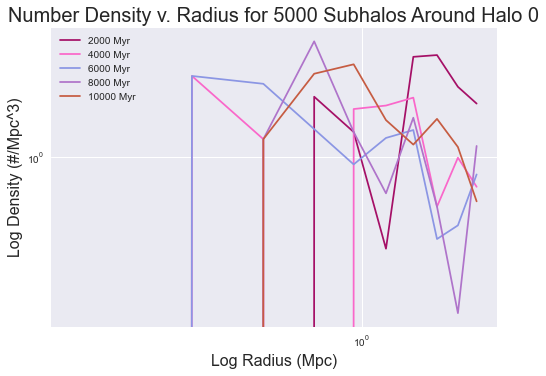

In [76]:
%matplotlib inline
plt.style.use('seaborn')
plt.title('Number Density v. Radius for 5000 Subhalos Around Halo 0', fontsize = 20)
plt.xlabel('Log Radius (Mpc)', fontsize = 16)
plt.ylabel('Log Density (#/Mpc^3)', fontsize = 16)
plt.semilogx()
plt.semilogy()

for i in range(1):
    for j in range(1,1+numsplit):
        r = np.random.random()
        g = np.random.random()
        b = np.random.random()
        color = (r,g,b)
        plt.plot(globals()['bm'+str(i)+'_'+str(j)], globals()['dm'+str(i)+'_'+str(j)], color=color, label = str(2*j)+'000 Myr')
        

plt.legend()

<font size = "5"> Mass vs. Radius </font>

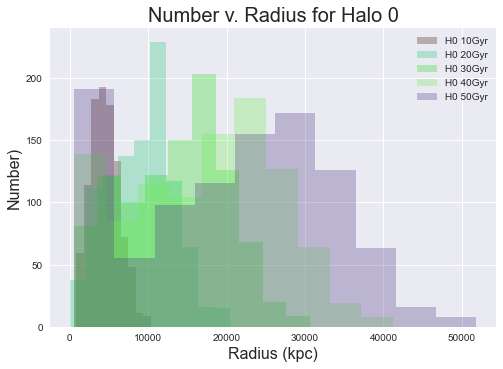

In [77]:
%matplotlib inline
plt.style.use('seaborn')
plt.title('Number v. Radius for Halo 0', fontsize = 20)
plt.xlabel('Radius (kpc)', fontsize = 16)
plt.ylabel('Number)', fontsize = 16)
for i in range(1):
    for j in range(1,1+numsplit):
        r = np.random.random()
        g = np.random.random()
        b = np.random.random()
        color = (r,g,b)
        plt.hist(globals()['r'+str(i)+'_'+str(j)], alpha = 0.3, color=color, label = 'H'+str(i)+' '+str(10*j)+'Gyr')
plt.legend()

<font size = "5">   </font>

<font size = "5">   </font>

<font size = "6"> **Phase Space Diagrams** </font>

<font size = "5"> Phase Space Diagram for Halos </font>

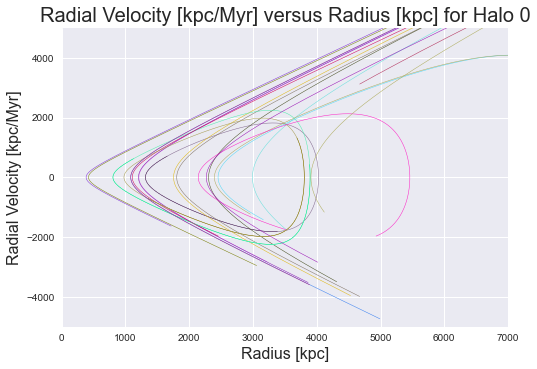

In [54]:
%matplotlib inline
plt.style.use('seaborn')
plt.title('Radial Velocity [kpc/Myr] versus Radius [kpc] for Halo 0', fontsize = 20)
plt.ylabel('Radial Velocity [kpc/Myr]', fontsize = 16)
plt.xlabel('Radius [kpc]', fontsize = 16)
plt.xlim(0,7000)
plt.ylim(-5000,5000)

for i in range(20):
    r = np.random.random()
    g = np.random.random()
    b = np.random.random()
    color = (r,g,b)
    plt.plot(g0['Radius'][i], g0['Vr'][i], color = color, linewidth = 0.5)
    

<font size = "5"> </font>

<font size = "5">  </font>

<font size = "6"> **Animating the Orbits** </font>

<font size = "5"> Animating One Orbit </font>

<IPython.core.display.Javascript object>


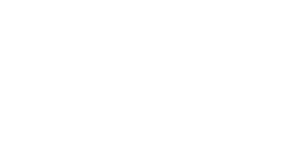

C:\Users\julia\anaconda3\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [55]:
%matplotlib notebook
def func(num, ds, l1):
    l1.set_data(ds[0:2, :num])    
    l1.set_3d_properties(ds[2, :num])
    return l1

cutarr = cutin20(g0['Orb_x'][0], g0['Orb_y'][0], g0['Orb_z'][0])
x = cutarr[0]
y = cutarr[1]
z = cutarr[2]
ds = np.array([x, y, z])
numdata = 625
#creates figure
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
l1 = plt.plot(ds[0], ds[1], ds[2], lw = 1, c = 'b')[0]
#again, creates a point for the center of the halo
ax.scatter3D(0, 0, 0, s = 30, c ='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Orbit')

anim = animation.FuncAnimation(fig, func, frames=numdata,
                        fargs=(ds, l1), interval=0.001, blit=True)
plt.show() 

# f = r"C:\Users\julia\Pictures\Research Summer 2022\correctorbit.mp4" 
# writervideo = animation.FFMpegWriter(fps=60) 
# anim.save(f, writer=writervideo)

<font size = "5"> </font>

<font size = "5"> </font>

<font size = "6"> **Incorporating Mass Evolution** </font>

<font size = "5"> Importing Mass Evolution Data </font>

In [56]:
massacc0df = pd.read_csv('halo0-75-massacc.csv')
massacc0 = massacc0df.to_dict('list')

2.409823958432979


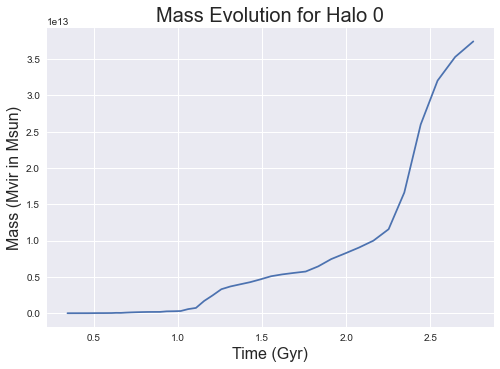

In [57]:
#mass v. time
#lower snapshot = lower time
masstime0 = {'Mass': [], 'Time' : []}
time, mass = [], []
time.clear()
mass.clear()
for i in range(len(massacc0['p.scale'])):
    mass.append(massacc0['p.Mvir'][i]*massacc0['p.scale'][i])
    time.append(calctime(massacc0['p.scale'][i]))
masstime0['Time'] = time
masstime0['Mass'] = mass

#max time difference given by CosmoSim in Gyr
print(max(masstime0['Time']) - min(masstime0['Time']))

%matplotlib inline
plt.style.use('seaborn')
plt.ylabel('Mass (Mvir in Msun)', fontsize = 16)
plt.xlabel('Time (Gyr)', fontsize = 16)
plt.title('Mass Evolution for Halo 0', fontsize = 20)
plt.plot(masstime0['Time'], masstime0['Mass'])

<font size = "5"> Adjusting the Code with Each Step </font>

In [58]:
def massevol(t):
    intfunc = interp1d(masstime0['Time'], masstime0['Mass'], fill_value = 'extrapolate')
    return intfunc(t)

for i in range(1):
    Mv = h500c['Mvir'][i]*subs['scale'][i]
    globals()['m' + str(i)] = {'Subhalo_ID' : [], 'Orb_x' : [], 'Orb_y' : [], 'Orb_z' : [], 'Vx':[],
                               'Vy':[], 'Vz':[], 'Time' : [], 'Radius' :[],'Vtot':[], 'Vr' : [], 'totE' : []}
    globals()['vtot' + str(i)], globals()['vr' + str(i)] = [], []
    for j in tqdm(range(100)):
        globals()['vtot' + str(i)].clear()
        globals()['vr' + str(i)].clear()
        x_arr, y_arr, z_arr, vx_arr, vy_arr, vz_arr, ke_orb, pe_orb = [],[],[],[],[],[],[],[]
        x_arr.clear()
        y_arr.clear()
        z_arr.clear()
        vx_arr.clear()
        vy_arr.clear()
        vz_arr.clear()
        for k in range(125):  #number of mass increases
            if k == 0:
                ics = gd.PhaseSpacePosition(pos=globals()['pos'+str(i)][j]*u.Mpc, vel=globals()['vel'+str(i)][j]*u.km/u.s )
            if k > 0:
                ics = gd.PhaseSpacePosition(pos=np.asarray([x_arr[-1],y_arr[-1],z_arr[-1]])*u.kpc,vel=np.asarray([vx_arr[-1],vy_arr[-1],vz_arr[-1]])*u.kpc/u.Myr)
            pot = gp.NFWPotential.from_M200_c(massevol(k*0.2)*u.Msun, c = h500c['Rvir'][0]/h500c['Rs'][0], rho_c = None, units=galactic)
            orbit = gp.Hamiltonian(pot).integrate_orbit(ics, dt=8*u.Myr, n_steps=25)
            for l in range(1, len(orbit.x)):
                x_arr.append(orbit.x[l].value)
                y_arr.append(orbit.y[l].value)
                z_arr.append(orbit.z[l].value)
                vx_arr.append(orbit.v_x[l].value)
                vy_arr.append(orbit.v_y[l].value)
                vz_arr.append(orbit.v_z[l].value)
        for h in range(len(vx_arr)):
            globals()['vtot' + str(i)].append(np.sqrt(vx_orb[h]**2 + vy_orb[h]**2 + vz_orb[h]**2))
            posit = np.empty(3)
            veloc = np.empty(3)
            posit = np.asarray([x_orbit[h],y_orbit[h],z_orbit[h]])
            veloc = np.asarray([vx_orb[h], vy_orb[h], vz_orb[h]])
            globals()['vr' + str(i)].append(vr(veloc, posit))
        globals()['m' + str(i)]['totE'].append(orbit.kinetic_energy()[-1].value + orbit.potential_energy()[-1].value)
        globals()['m' + str(i)]['Subhalo_ID'].append(j)
        globals()['m' + str(i)]['Orb_x'].append(np.asarray(x_arr))
        globals()['m' + str(i)]['Orb_y'].append(np.asarray(y_arr))
        globals()['m' + str(i)]['Orb_z'].append(np.asarray(z_arr))
        globals()['m' + str(i)]['Vx'].append(np.asarray(vx_arr))
        globals()['m' + str(i)]['Vy'].append(np.asarray(vy_arr))
        globals()['m' + str(i)]['Vz'].append(np.asarray(vz_arr))
        globals()['m' + str(i)]['Time'].append(np.asarray(orbit.t))
        globals()['m' + str(i)]['Radius'].append(xyzradius(x_arr, y_arr, z_arr))
        globals()['m' + str(i)]['Vtot'].append(np.asarray(globals()['vtot' + str(i)]))
        globals()['m' + str(i)]['Vr'].append(np.asarray(globals()['vr' + str(i)]))

100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


In [59]:
len(m0['Radius'][0])

3125

<font size = "5"> Plotting Orbit with Mass Evolution </font>

<IPython.core.display.Javascript object>


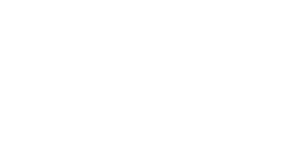

<IPython.core.display.Javascript object>


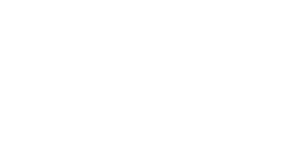

In [60]:
%matplotlib notebook
plt.style.use('seaborn')
ax = plt.axes(projection='3d')
fig = plt.figure()
ax.set_xlabel('x', fontsize = 18)
ax.set_ylabel('y', fontsize = 18)
ax.set_zlabel('z', fontsize = 18)
ax.set_title('Orbits around Halo 0', fontsize = 20)
ax.scatter3D(0, 0, 0, s = 20, c ='k')
ax.set_xlim(-5000, 5000)
ax.set_ylim(-5000, 5000)
ax.set_zlim(-5000, 5000)

for i in range(10):
    r = np.random.random()
    g = np.random.random()
    b = np.random.random()
    color = (r,g,b)
    ax.plot3D(m0['Orb_x'][i], m0['Orb_y'][i], m0['Orb_z'][i],
              color = color, linewidth = 0.4)

<font size = "5">   </font>

<font size = "5">   </font>

<font size = "6"> **Parametrizing Distributions for Many Halos** </font>

<font size = "5"> Parametrizing Angular Momentum Distributions </font>

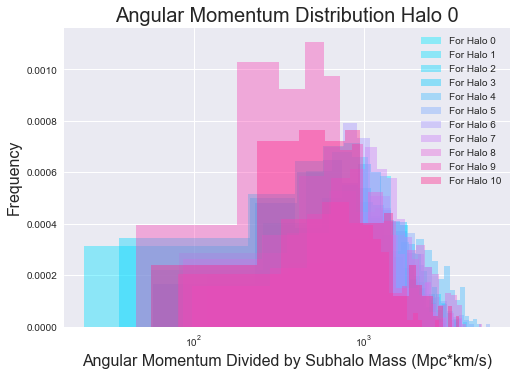

In [61]:
%matplotlib inline
plt.style.use('seaborn')
plt.xlabel('Angular Momentum Divided by Subhalo Mass (Mpc*km/s)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Angular Momentum Distribution Halo 0', fontsize = 20)
plt.semilogx()
co = np.asarray(["#00eaff","#00e1ff","#00d6ff","#00caff","#41bbff","#7baaff","#a796ff","#cb7ef9","#e664da","#f947b5","#ff268b","#ff0060"])
for i in range(len(toth500c['x'])):
    plt.hist(globals()['h'+ str(i)]['totang'], bins = 20, density = True, alpha = 0.4,
             color = co[i], label = 'For Halo '+ str(i))
plt.legend()

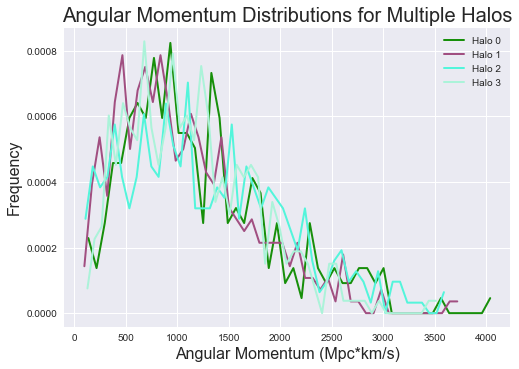

In [62]:
for i in range(len(toth500c['x'])):
    globals()['h'+str(i)]['angm_count'] =[]
    globals()['h'+str(i)]['angm_bin']=[]
    globals()['h'+str(i)]['angm_count'].clear()
    globals()['h'+str(i)]['angm_bin'].clear()
    a, b = np.histogram(globals()['h'+str(i)]['totang'], bins = 50, density = True)
    globals()['h'+str(i)]['angm_count'] = a
    globals()['h'+str(i)]['angm_bin'] = b[1:]    
    
%matplotlib inline
plt.style.use('seaborn')
plt.title('Angular Momentum Distributions for Multiple Halos', fontsize = 20)
plt.ylabel('Frequency', fontsize = 16)
plt.xlabel('Angular Momentum (Mpc*km/s)', fontsize = 16)

for i in range(len(h500c['x'])):
    r = np.random.random()
    g = np.random.random()
    b = np.random.random()
    color = (r,g,b)
    plt.plot(globals()['h'+str(i)]['angm_bin'], globals()['h'+str(i)]['angm_count'], color = color, linewidth = 2, label = 'Halo ' + str(i))
    
plt.legend()

<font size = "5"> Use Curve Fit to Estimate Parameters -- Assume Gaussian </font>

[2.86652073e+00 2.01196783e-01 6.88045502e-04]


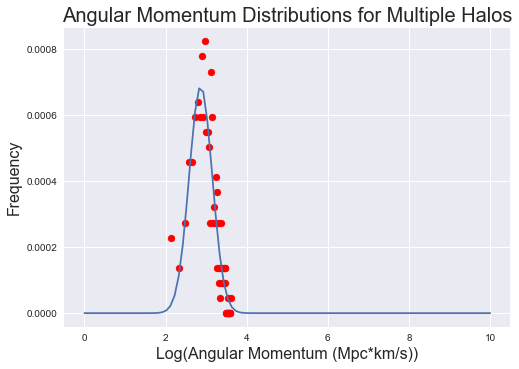

In [63]:
def gauss(x, mu, sigma, a):
    return a*np.exp((-1/2)*((x-mu)**2/(2*sigma**2)))

def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

param, covar = curve_fit(gauss, np.log10(h0['angm_bin']), h0['angm_count'])
print(param)

%matplotlib inline
plt.style.use('seaborn')
plt.title('Angular Momentum Distributions for Multiple Halos', fontsize = 20)
plt.ylabel('Frequency', fontsize = 16)
plt.xlabel('Log(Angular Momentum (Mpc*km/s))', fontsize = 16)
x = np.linspace(0,10, 100)
plt.plot(x, gauss(x,param[0],param[1],param[2]))
plt.scatter(np.log10(h0['angm_bin']), h0['angm_count'], color = 'r')

<font size = "5"> Using Beta Distribution to Fit Angular Momentum </font>

In [64]:
#beta distribution also works nicely
for i in range(len(toth500c['x'])):
    globals()['b_param'+str(i)] = scipy.stats.beta.fit(globals()['h'+str(i)]['totang'])

C:\Users\julia\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


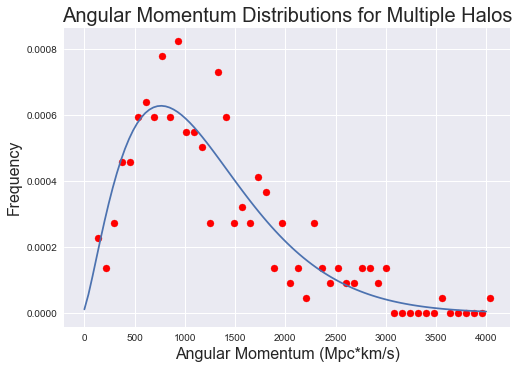

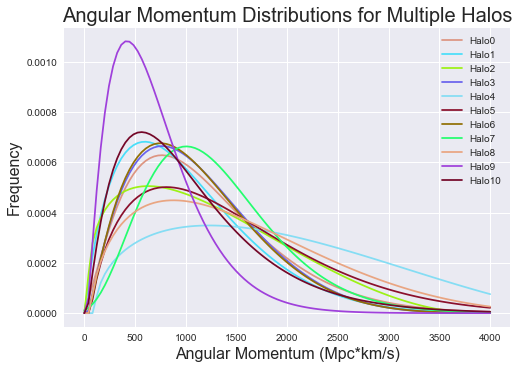

In [65]:
%matplotlib inline
plt.style.use('seaborn')
plt.title('Angular Momentum Distributions for Multiple Halos', fontsize = 20)
plt.ylabel('Frequency', fontsize = 16)
plt.xlabel('Angular Momentum (Mpc*km/s)', fontsize = 16)
x = np.linspace(0,4000,100)
plt.plot(x, beta.pdf(x,b_param0[0],b_param0[1],b_param0[2], b_param0[3]))
plt.scatter(h0['angm_bin'], h0['angm_count'], color = 'r')
plt.show()

%matplotlib inline
plt.style.use('seaborn')
plt.title('Angular Momentum Distributions for Multiple Halos', fontsize = 20)
plt.ylabel('Frequency', fontsize = 16)
plt.xlabel('Angular Momentum (Mpc*km/s)', fontsize = 16)
x = np.linspace(0,4000,100)

for i in range(len(toth500c['x'])):
    r = np.random.random()
    g = np.random.random()
    b = np.random.random()
    color = (r,g,b)
    plt.plot(x, beta.pdf(x,globals()['b_param'+str(i)][0],globals()['b_param'+str(i)][1],
                         globals()['b_param'+str(i)][2], globals()['b_param'+str(i)][3]), color = color, label = 'Halo'+str(i))
plt.legend()

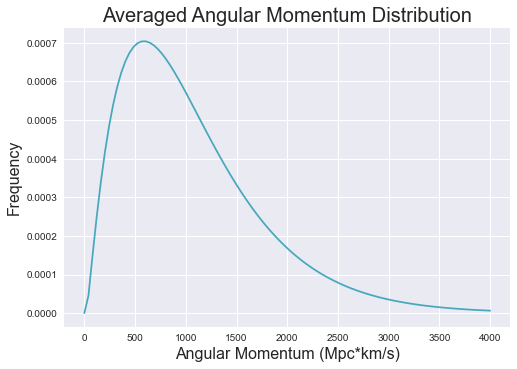

In [66]:
#now let's average all of the profiles
param1, param2, param3, param4 = [],[],[],[]
param1.clear()
param2.clear()
param3.clear()
param4.clear()
for i in range(len(toth500c['x'])):
    param1.append(globals()['b_param'+str(i)][0])
    param2.append(globals()['b_param'+str(i)][1])
    param3.append(globals()['b_param'+str(i)][2])
    param4.append(globals()['b_param'+str(i)][3])

%matplotlib inline
plt.style.use('seaborn')
plt.title('Averaged Angular Momentum Distribution', fontsize = 20)
plt.ylabel('Frequency', fontsize = 16)
plt.xlabel('Angular Momentum (Mpc*km/s)', fontsize = 16)
x = np.linspace(0,4000,100)
plt.plot(x, beta.pdf(x,np.mean(param1),np.mean(param2), np.mean(param3),np.mean(param4)), color = '#47a8bd')

<font size = "5">   </font>

<font size = "5">  </font>

<font size = "6"> **Checking Bound Orbits** </font>

<font size = "5"> For Non-Mass Evolved Orbits </font>

In [67]:
for i in range(len(h500c['x'])):
    globals()['g'+str(i)]['totE'] = []
    globals()['g'+str(i)]['totE'].clear()
    tot_E = []
    tot_E.clear()
    for j in range(len(globals()['g'+str(i)]['KE'])):
        tot_E.append(globals()['g'+str(i)]['KE'][j][0]+globals()['g'+str(i)]['PE'][j][0])
        globals()['g'+str(i)]['totE'] = tot_E       

<font size = "5"> For Mass Evolved Orbits </font>

In [68]:
for i in range(len(m0['totE'])):
    if m0['totE'][i] > 0:
        print("UNBOUND")
    else:
        pass
    
#to create a custom potential with an "inner" and an "outer" can use composite potential in Gala!

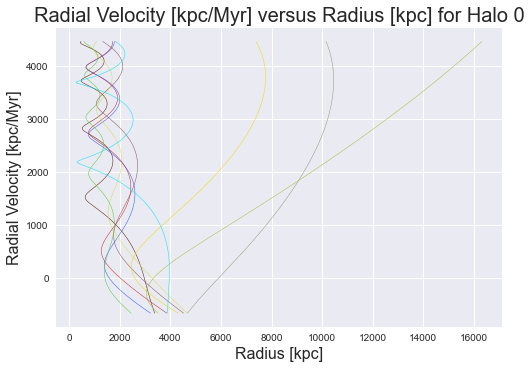

In [69]:
%matplotlib inline
plt.style.use('seaborn')
plt.title('Radial Velocity [kpc/Myr] versus Radius [kpc] for Halo 0', fontsize = 20)
plt.ylabel('Radial Velocity [kpc/Myr]', fontsize = 16)
plt.xlabel('Radius [kpc]', fontsize = 16)

for i in range(10):
    r = np.random.random()
    g = np.random.random()
    b = np.random.random()
    color = (r,g,b)
    plt.plot(m0['Radius'][i], m0['Vr'][i], color = color, linewidth = 0.5)
    